# Stock Prediction with SciKit learn
#### Step 1:
Go to Yahoo Finance and find a stock price that you want to predict. Click on historical data, then download the CSV of that stocks price history https://finance.yahoo.com/quote/AAPL/history?p=AAPL  

In [1]:
# !pip install pandas_datareader
%matplotlib inline

In [2]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

start = datetime.datetime(2010, 1, 1)
end = datetime.date.today()

df = web.DataReader("GOOG", "yahoo", start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-16,1239.560059,1225.609985,1229.520020,1231.300049,1053300.0,1231.300049
2019-09-17,1235.000000,1223.689941,1230.400024,1229.150024,955100.0,1229.150024
2019-09-18,1235.609985,1216.530029,1227.510010,1232.410034,1135100.0,1232.410034
2019-09-19,1244.439941,1232.020020,1232.060059,1238.709961,996000.0,1238.709961
2019-09-20,1243.319946,1223.079956,1233.119995,1229.930054,2270000.0,1229.930054


#### Step 2:
Use Scikit learn to try out 3 different types of regression models to predict the price of that stock for a future date.

In [3]:
"""
Feature Engineering: High Low Percentage and Percentage Change.
"""
dfreg = df.loc[:,["Adj Close","Volume"]]
# dfreg["HL_PCT"] = df["High"] — df["Low"]/df["Close"] * 100.0
dfreg["HL_PCT"] = df["High"] - df["Low"] / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0
dfreg.info()
dfreg.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2446 entries, 2010-01-04 to 2019-09-20
Data columns (total 4 columns):
Adj Close     2446 non-null float64
Volume        2446 non-null float64
HL_PCT        2446 non-null float64
PCT_change    2446 non-null float64
dtypes: float64(4)
memory usage: 95.5 KB


,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-09-16,1231.300049,1053300.0,1140.022177,0.144774
2019-09-17,1229.150024,955100.0,1135.444216,-0.101593
2019-09-18,1232.410034,1135100.0,1136.898518,0.399184
2019-09-19,1238.709961,996000.0,1144.980015,0.539738
2019-09-20,1229.930054,2270000.0,1143.876896,-0.258689


#### Pre-processing & Cross Validation
We will clean up and process the data using the following steps before putting them into the prediction models:
 - Drop missing value
 - Separating the label here, we want to predict the AdjClose
 - Scale the X so that everyone can have the same distribution for linear regression
 - Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
 - Separate label and identify it as y
 
Separation of training and testing of model by cross validation train test split

In [4]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

#### Scikit-Learn library and train the model by selecting our x and y train sets.

In [5]:
# Test / Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

#### Evaluation

In [6]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  0.9819172193643292
The quadratic regression 2 confidence is  0.9824445543657125
The quadratic regression 3 confidence is  0.9827562157636248
The knn regression confidence is  0.9752858577498917


#### Printing some of the stock forecasting charts.

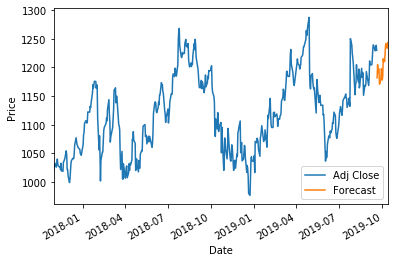

In [7]:
# Linear regression forecast
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

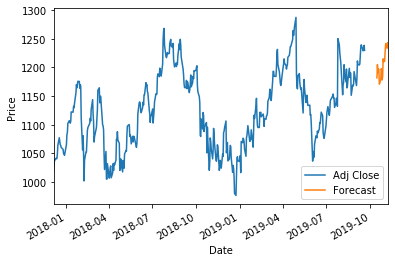

In [8]:
# Quadratic Regression 2 forecast
forecast_set_0 = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

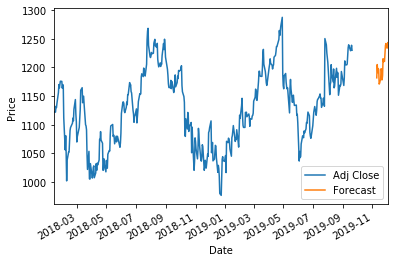

In [9]:
# Quadratic Regression 3 forecast
forecast_set_1 = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

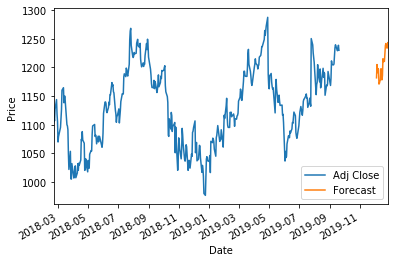

In [10]:
# KNN Regression
forecast_set_2 = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()